<a href="https://colab.research.google.com/github/christmasv/Proyectos-de-ML/blob/Clasificacion-Aprendizaje-Supervisado/Reating_crediticio_modelo_clasificacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicción de Incumplimiento de Préstamos: Construyendo un Modelo ML para la Evaluación del Riesgo del Solicitante!**


**Author** = [Christopher Soto](https://twitter.com/csv_81)

    @article{khrizoto,     
    Title        = {Predicción de Incumplimiento de Préstamos},
    Howpublished = {\url{https://khrizoto.wordpress.com/}},
    Year         = {2024}
    

**Descripción:**

En el mundo financiero, la concesión de préstamos es una práctica común que implica un cierto grado de riesgo para las instituciones crediticias. Una de las preocupaciones principales para estas instituciones es la posibilidad de que los solicitantes de préstamos no cumplan con sus obligaciones financieras, lo que puede resultar en pérdidas significativas. Identificar de manera precisa y oportuna a los solicitantes con mayor riesgo de incumplimiento es fundamental para mitigar estos riesgos y mantener la estabilidad financiera.

En este contexto, el uso de técnicas avanzadas de aprendizaje automático se ha vuelto indispensable. Estas técnicas permiten analizar grandes volúmenes de datos para identificar patrones y correlaciones que pueden predecir el riesgo de incumplimiento de un préstamo. Este proyecto se centra en la construcción de un modelo de aprendizaje automático diseñado específicamente para predecir si un solicitante de préstamo tiene una alta probabilidad de no devolver el préstamo. Al hacerlo, se busca proporcionar a las instituciones financieras una herramienta eficaz para evaluar el riesgo crediticio y tomar decisiones informadas al otorgar préstamos.

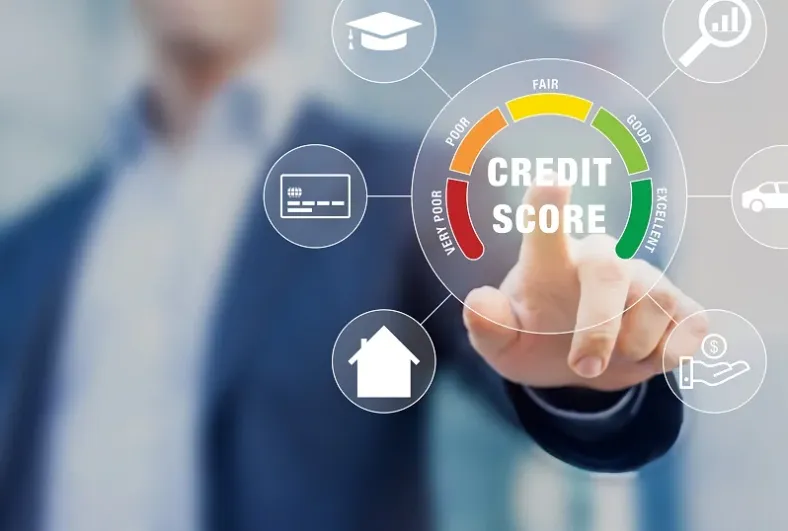

# Acerca del conjunto de datos
# **Contexto**
Contexto de las 21 variables del conjunto de datos:

1. **Unnamed: 0**: Este parece ser un índice o identificador único para cada registro en el conjunto de datos.
2. **status**: Estado del préstamo. En este caso, todos los préstamos están marcados como "Charged Off" (Incumplido), "Default" (Incumplido) "Fully Paid" (Totalmente Pagado).
3. **loan_amnt**: Cantidad del préstamo solicitado.
4. **term**: Plazo del préstamo en meses.
5. **annual_inc**: Ingreso anual del prestatario.
6. **dti (Debt-to-Income Ratio)**: Relación entre la deuda total del prestatario y su ingreso anual.
7. **payment_inc_ratio**: Relación entre el ingreso del prestatario y la cantidad de pago mensual.
8. **revol_bal**: Saldo revolvente, es decir, la cantidad pendiente de pago en todas las cuentas de crédito del prestatario.
9. **revol_util**: Porcentaje de la línea de crédito utilizada por el prestatario.
10. **purpose**: Propósito del préstamo.
11. **home_ownership**: Tipo de propiedad del hogar del prestatario.
12. **delinq_2yrs_zero**: Indica si el prestatario ha tenido algún retraso en los pagos en los últimos 2 años.
13. **pub_rec_zero**: Indica si el prestatario tiene registros públicos.
13. **open_acc**: Número de cuentas abiertas del prestatario.
14. **grade**: Medida de la calidad crediticia del prestatario, posiblemente asignada por la institución crediticia.
15. **outcome**: Resultado del préstamo. "defaul' (incumplido) y "paid off" (pagado).
16. **emp_length**: Cantidad de tiempo que el prestatario ha estado empleado.
17. **purpose_**: Versión codificada de la variable "purpose".
18. **home_**: Versión codificada de la variable "home_ownership".
19. **emp_len_**: Versión codificada de la variable "emp_length" "> 1 Year" (mayor a 1 año) y "< 1 Year" (menor a 1 año).
20. **borrower_score**: Puntuación asignada al prestatario, posiblemente basada en su historial crediticio y otros factores.

* Número de instancias: 45,342
* Número de atributos: 21
* Valores faltantes: 0

**Fuentes Datos**:

# 0. Preparando entorno

In [ ]:
# Instalar paquetes necesarios <--
!pip install pygam
!pip install dmba

In [2]:
#importacion de librerias Necesarias
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression #, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score

import statsmodels.api as sm

from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from pygam import LinearGAM, s, f, l


from dmba import classificationSummary

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline


Colab environment detected.


In [3]:
## configuracion inicial viz ##
sns.set(font_scale=1.0)
col = '#3B1C8C'
cm = 'viridis'

In [4]:
try:
    import common
    DATA = common.dataDirectory()
except ImportError:
    DATA = Path().resolve() / ''

# 1. Carga y análsisde Dataset

In [5]:
# Definir rutas a conjuntos de datos.

#LOAN3000_CSV = DATA / 'loan3000.csv'
LOAN_DATA_CSV = DATA / 'loan_data.csv.gz'
#FULL_TRAIN_SET_CSV = DATA / 'full_train_set.csv.gz'


In [6]:
!ls /content/

loan_data.csv.gz  sample_data


In [7]:
#!git clone https://github.com/christmasv/Proyectos-de-ML.git

In [7]:
loan_data = pd.read_csv(LOAN_DATA_CSV)


# 1.1 Analisis Exploratorio de los Datos

In [8]:
loan_data.describe()

,Unnamed: 0,loan_amnt,annual_inc,dti,payment_inc_ratio,revol_bal,revol_util,delinq_2yrs_zero,pub_rec_zero,open_acc,grade,emp_length,borrower_score
count,45342.00000,45342.000000,4.534200e+04,45342.000000,45342.000000,4.534200e+04,45342.000000,45342.000000,45342.000000,45342.000000,45342.000000,45342.000000,45342.000000
mean,22671.50000,13154.814521,6.821170e+04,16.133731,8.032225,1.485745e+04,56.051800,0.857527,0.912090,10.413105,4.599087,6.321115,0.499006
std,13089.25229,8088.533525,5.623902e+04,7.594881,4.264034,2.008254e+04,25.430276,0.349538,0.283167,4.696616,1.479069,3.752789,0.128687
min,1.00000,500.000000,2.000000e+03,0.000000,0.048892,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.050000
25%,11336.25000,7000.000000,4.200000e+04,10.460000,4.671572,5.657000e+03,37.900000,1.000000,1.000000,7.000000,3.600000,3.000000,0.400000
50%,22671.50000,11500.000000,6.000000e+04,16.020000,7.499355,1.076550e+04,58.400000,1.000000,1.000000,10.000000,4.800000,6.000000,0.500000
75%,34006.75000,18000.000000,8.100000e+04,21.590000,10.940575,1.861350e+04,76.400000,1.000000,1.000000,13.000000,5.800000,11.000000,0.600000
max,45342.00000,35000.000000,7.141778e+06,38.860000,43.545600,1.743266e+06,128.100000,1.000000,1.000000,76.000000,7.000000,11.000000,1.000000


In [9]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45342 entries, 0 to 45341
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         45342 non-null  int64  
 1   status             45342 non-null  object 
 2   loan_amnt          45342 non-null  int64  
 3   term               45342 non-null  object 
 4   annual_inc         45342 non-null  int64  
 5   dti                45342 non-null  float64
 6   payment_inc_ratio  45342 non-null  float64
 7   revol_bal          45342 non-null  int64  
 8   revol_util         45342 non-null  float64
 9   purpose            45342 non-null  object 
 10  home_ownership     45342 non-null  object 
 11  delinq_2yrs_zero   45342 non-null  int64  
 12  pub_rec_zero       45342 non-null  int64  
 13  open_acc           45342 non-null  int64  
 14  grade              45342 non-null  float64
 15  outcome            45342 non-null  object 
 16  emp_length         453

In [10]:
loan_data.head()

,Unnamed: 0,status,loan_amnt,term,annual_inc,dti,payment_inc_ratio,revol_bal,revol_util,purpose,...,delinq_2yrs_zero,pub_rec_zero,open_acc,grade,outcome,emp_length,purpose_,home_,emp_len_,borrower_score
0,1,Charged Off,2500,60 months,30000,1.00,2.39320,1687,9.4,car,...,1,1,3,4.8,default,1,major_purchase,RENT,> 1 Year,0.65
1,2,Charged Off,5600,60 months,40000,5.55,4.57170,5210,32.6,small_business,...,1,1,11,1.4,default,5,small_business,OWN,> 1 Year,0.80
2,3,Charged Off,5375,60 months,15000,18.08,9.71600,9279,36.5,other,...,1,1,2,6.0,default,1,other,RENT,> 1 Year,0.60
3,4,Charged Off,9000,36 months,30000,10.08,12.21520,10452,91.7,debt_consolidation,...,1,1,4,4.2,default,1,debt_consolidation,RENT,> 1 Year,0.50
4,5,Charged Off,10000,36 months,100000,7.06,3.90888,11997,55.5,other,...,1,1,14,5.4,default,4,other,RENT,> 1 Year,0.55


In [11]:
loan_data.drop(['Unnamed: 0'], axis=1, inplace=True)

In [12]:
categorical_atts = ['status','term','purpose','home_ownership','outcome','purpose_','home_','emp_len_']
numerical_atts = loan_data.drop(columns=categorical_atts).columns.to_list()


In [13]:
# número de valores únicos en atributos categóricos
loan_data[categorical_atts].nunique()

status             3
term               2
purpose           12
home_ownership     4
outcome            2
purpose_           7
home_              3
emp_len_           2
dtype: int64

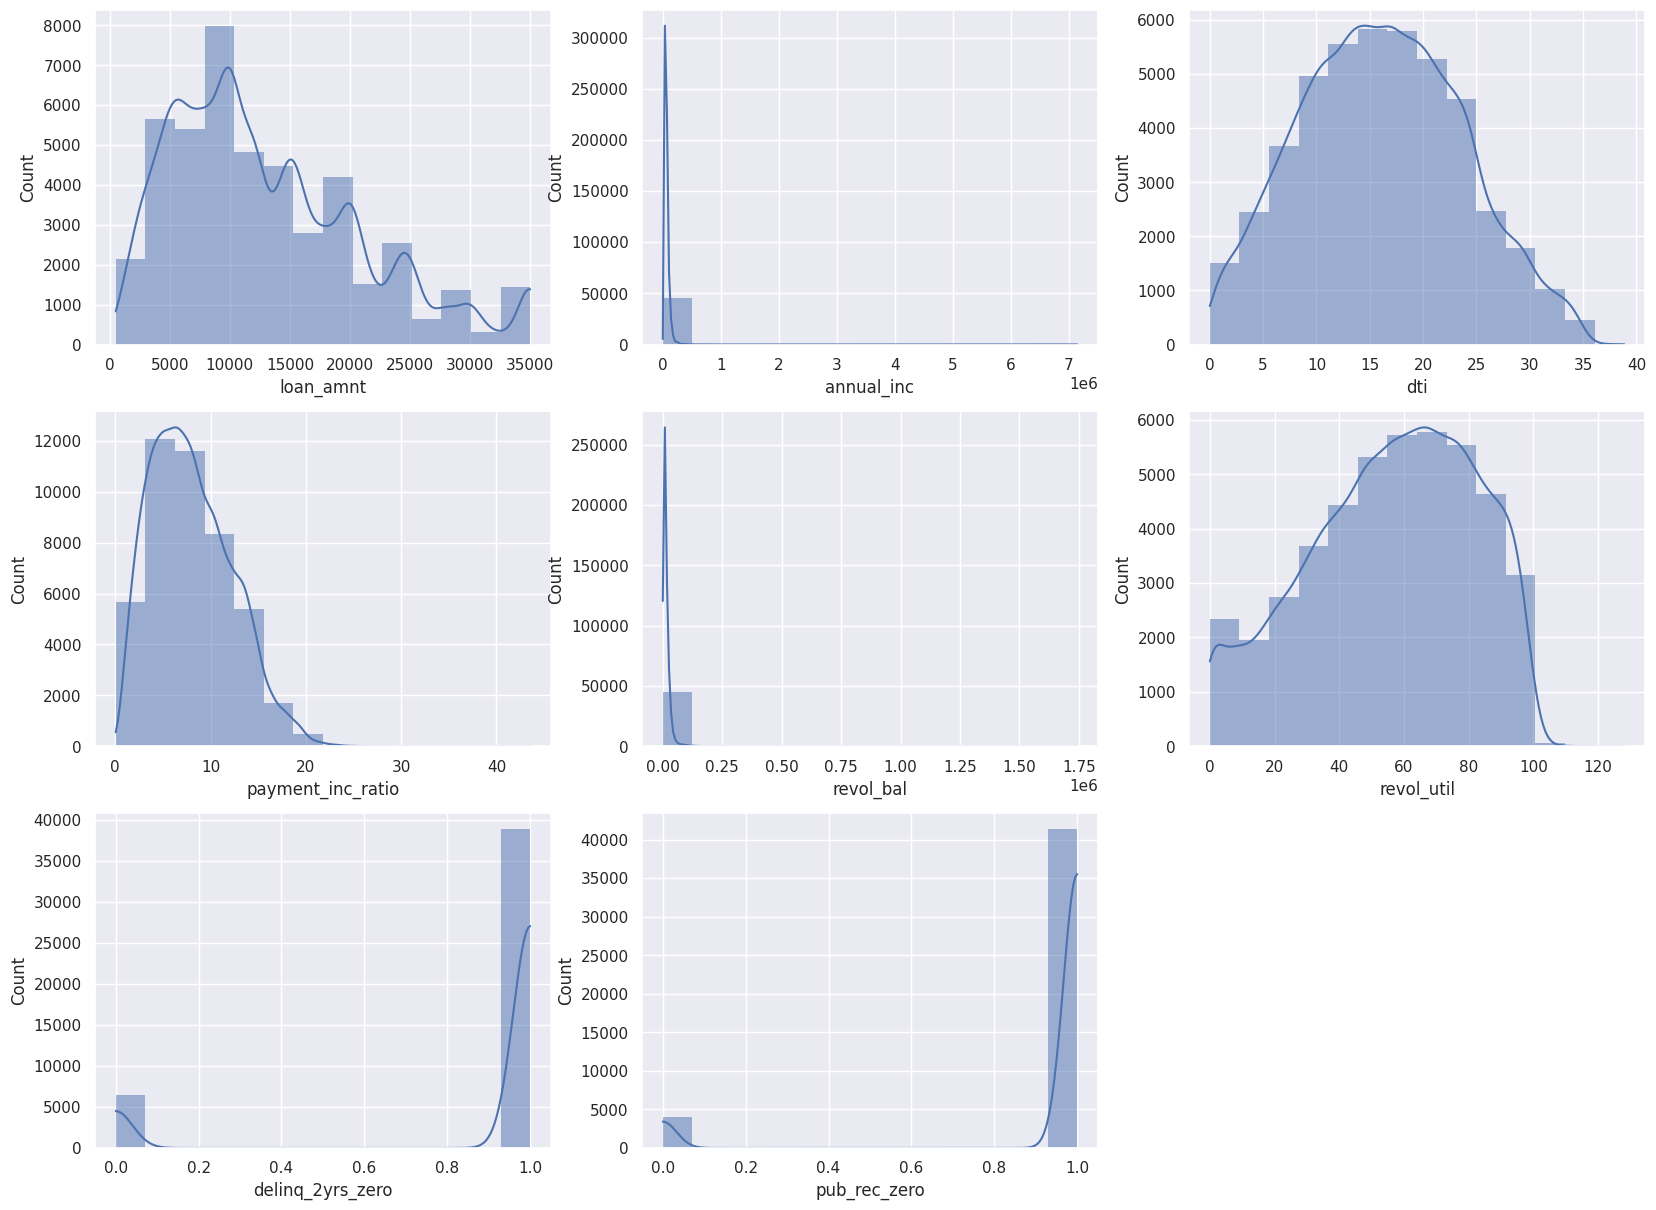

In [14]:
# graficamos la distribucion de las variables numericas
num_df = loan_data[numerical_atts]
plt.figure(figsize=(20,20))
for i in range(1, 9):
    plt.subplot(4, 3, i)
    sns.histplot(num_df[num_df.columns[i-1]],bins=14, kde=True, linewidth=0)

<ipython-input-15-ed342eceebb1>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(data=loan_data, x='outcome', kind= 'count', height=4, aspect=4, palette='muted')


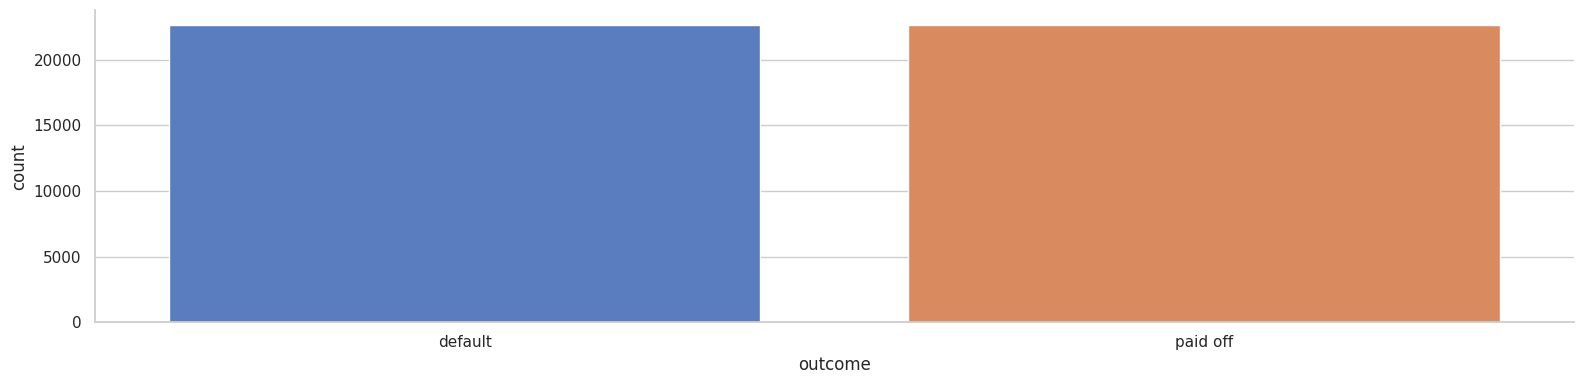

In [15]:
# graficamos como esta distribuida la variable "outcome"
sns.set_style("whitegrid")
sns.catplot(data=loan_data, x='outcome', kind= 'count', height=4, aspect=4, palette='muted')

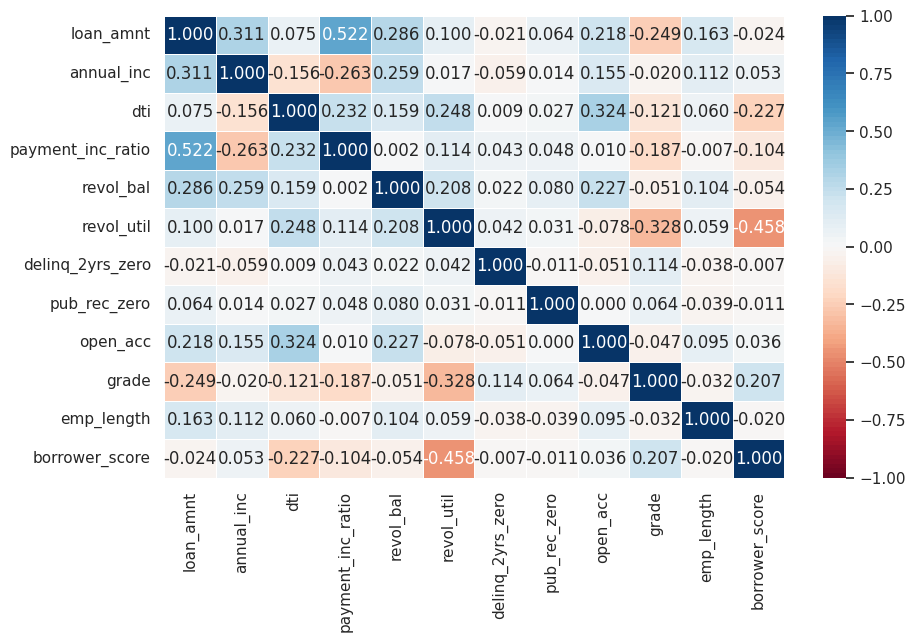

In [16]:
# creamos la matríz de correlación
num_corr = num_df.corr()
plt.figure(figsize=(10,6))
sns.heatmap(num_corr, annot=True, fmt=".3f",vmin=-1, vmax=1, linewidths=.5, cmap = sns.color_palette("RdBu", 100))
plt.yticks(rotation=0)
plt.show()

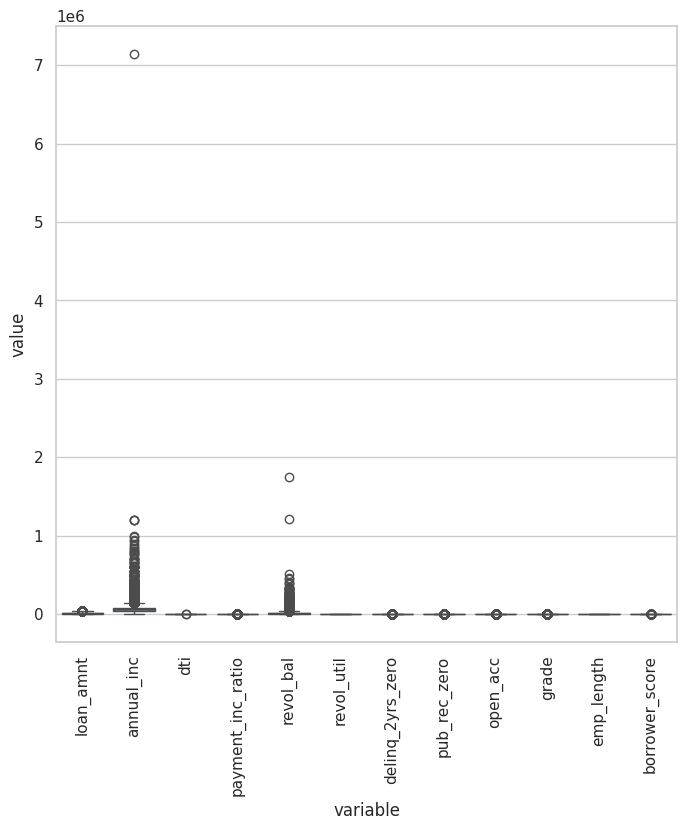

In [17]:
# Graficamos boxplots para resumir la distribución de datos cuantitativos, esto nos permite identificar rápidamente la mediana, los cuartiles, la asimetría y la presencia de valores atípicos en un conjunto de datos
plt.figure(figsize=(8,8))
sns.boxplot(x="variable", y="value", data=pd.melt(num_df))
plt.xticks(rotation=90)
plt.show()


# Preprocesamiento del dataset

In [18]:
# Dividimos la variales numericas y categoricas
# convertir a variables categoricas
loan_data.outcome = loan_data.outcome.astype('category')
loan_data.outcome.cat.reorder_categories(['paid off', 'default'])
loan_data.purpose_ = loan_data.purpose_.astype('category')
loan_data.home_ = loan_data.home_.astype('category')
loan_data.emp_len_ = loan_data.emp_len_.astype('category')
predictors = ['purpose_', 'home_', 'emp_len_']
outcome = 'outcome'

# Modelo de Machine Learning

El modelo de clasificación de **Bayes ingenuo** es una técnica de aprendizaje automático que se basa en el teorema de Bayes y asume independencia condicional entre las variables predictoras. En nuestro proyecto de machine learning, utilizamos este modelo para predecir la probabilidad de ocurrencia de un evento (por ejemplo, el impago de un préstamo) dado otro evento (por ejemplo, el historial crediticio del solicitante).


Para ello, calculamos la probabilidad condicional de observar ciertos eventos dados otros eventos, utilizando la fórmula P(Xi | Yi). Además, empleamos la probabilidad a posteriori, que es la probabilidad de un resultado después de haber incorporado la información de las variables predictoras. Esto nos permite evaluar el riesgo crediticio de manera más precisa al tener en cuenta información relevante, como el salario, historial crediticio y situación laboral del solicitante.

# Modelo de Bayes Ingenuo

In [19]:
X = pd.get_dummies(loan_data[predictors], prefix='', prefix_sep='', dtype=int)
y = loan_data[outcome]

naive_model = MultinomialNB(alpha=0.01, fit_prior=True)
naive_model = MultinomialNB(alpha=1e-10, fit_prior=False)
naive_model.fit(X, y)

new_loan = X.loc[146:146, :]
print('predicted class: ', naive_model.predict(new_loan)[0])

probabilities = pd.DataFrame(naive_model.predict_proba(new_loan),
                             columns=naive_model.classes_)
print('predicted probabilities',)
print(probabilities)

predicted class:  default
predicted probabilities
    default  paid off
0  0.653699  0.346301


El resultado de aplicar Naive Bayes muestra las predicciones de clase y las probabilidades asociadas a cada clase para un caso específico. En este caso:

La clase predicha es "default" (incumplimiento).
Las probabilidades predichas son aproximadamente 0.654 para "default" (incumplimiento) y 0.346 para "paid off" (pagado).

Esto significa que, según el modelo Naive Bayes, hay una probabilidad estimada del 65.37% de que el caso pertenezca a la clase "default" (incumplimiento) y una probabilidad del 34.63% de que pertenezca a la clase "paid off" (pagado).

En resumen, el modelo predice que existe una mayor probabilidad de que el caso se clasifique como "default" (incumplimiento) en comparación con "paid off" (pagado). Sin embargo, la probabilidad de "paid off" aún es considerable.

# Guardar el Modelo y Deploy

In [21]:
import pickle

#Guardando el modelo
with open('model', 'wb') as file:
    pickle.dump(probabilities, file)


# Cita Bibliográficas
**Citas Bibliográficas** =

         
    Title   = {Estadística práctica para ciencia de datos con R y Python},
    Author  = {Peter Bruce, Andrew Bruce y Peter Gedeck},
    Year    = {2022},
    Pages   = {192 – 198},
    Editors = {Marcombo y O’Reilly.},
    ISBN    = {978-84-267-3443-3},
    url     = {http://www.marcambro.info}

    









